### Import Libraries

In [3]:
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Dataset

In [5]:
from torch_geometric.datasets import Planetoid,KarateClub

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="cora")

data = dataset[0]


Processing...
Done!


### Print information about the dataset

In [6]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: cora()
-------------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [7]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 0


### Plot dataset

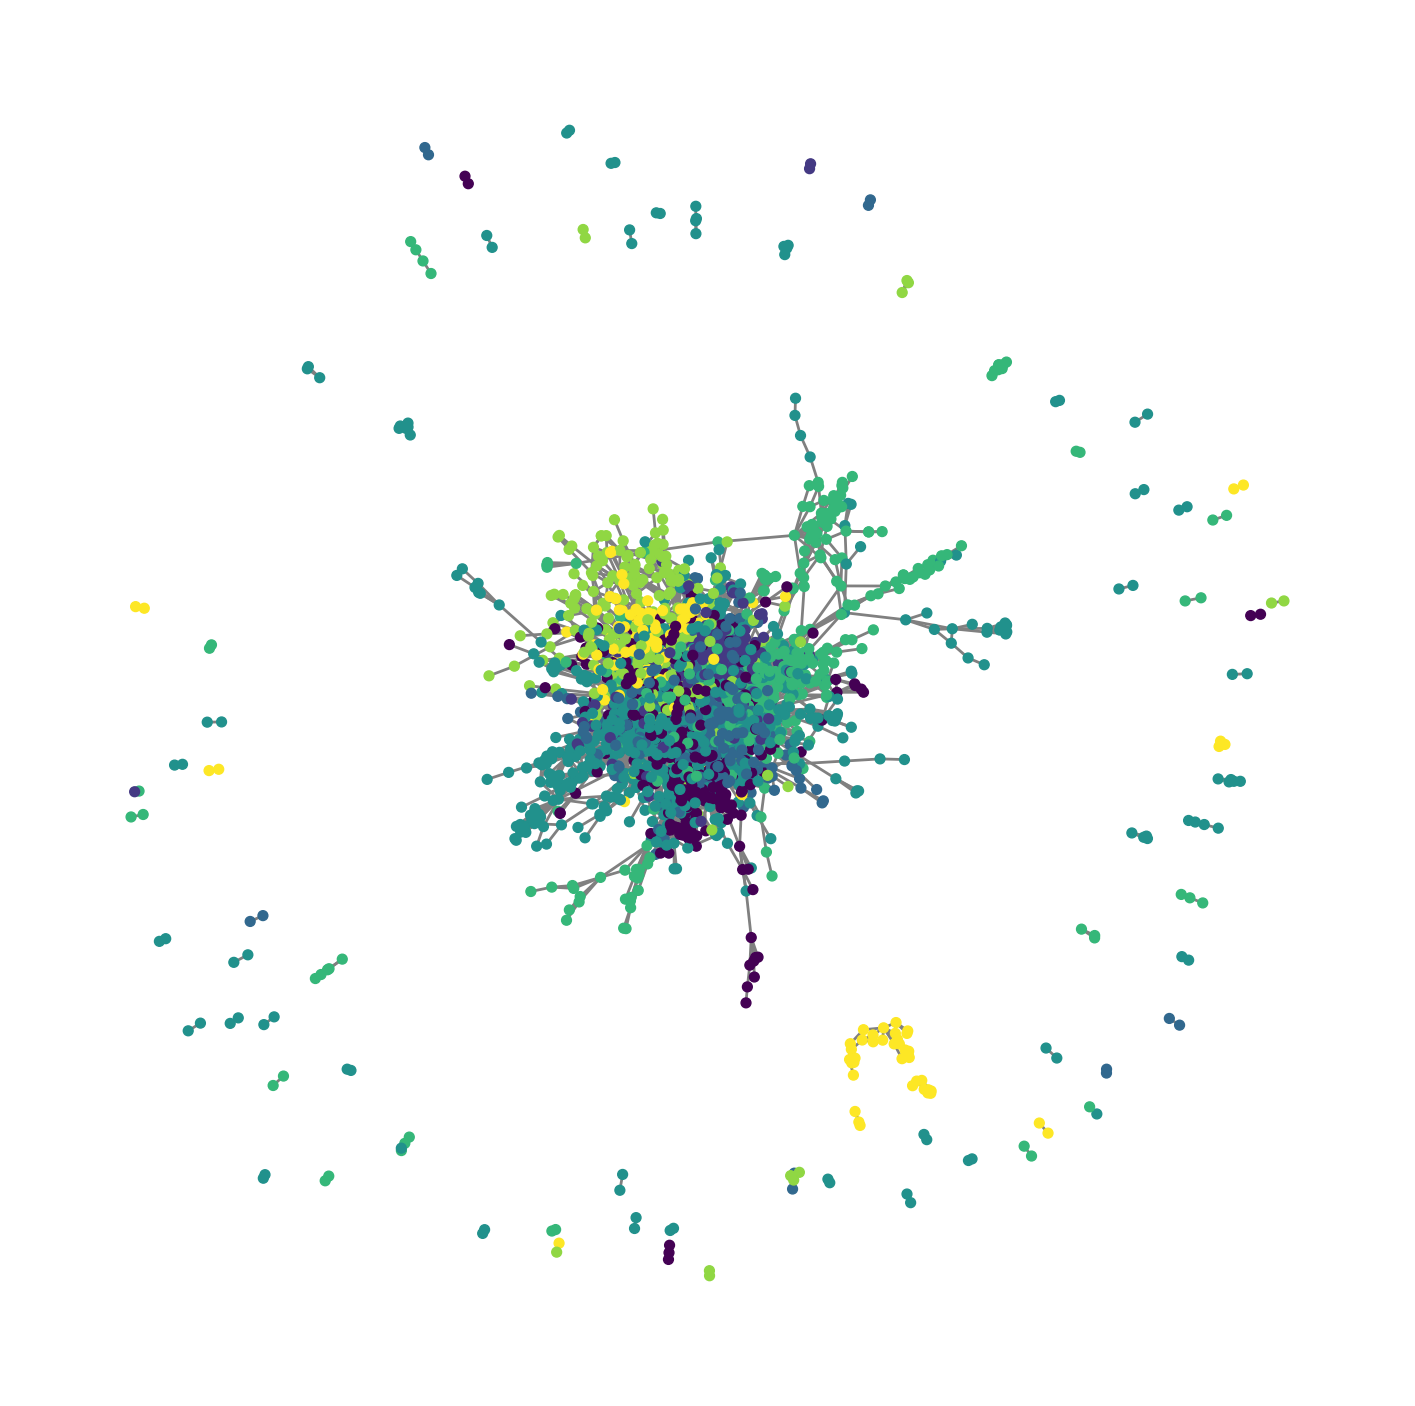

In [8]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

### Plot node degrees

<BarContainer object of 37 artists>

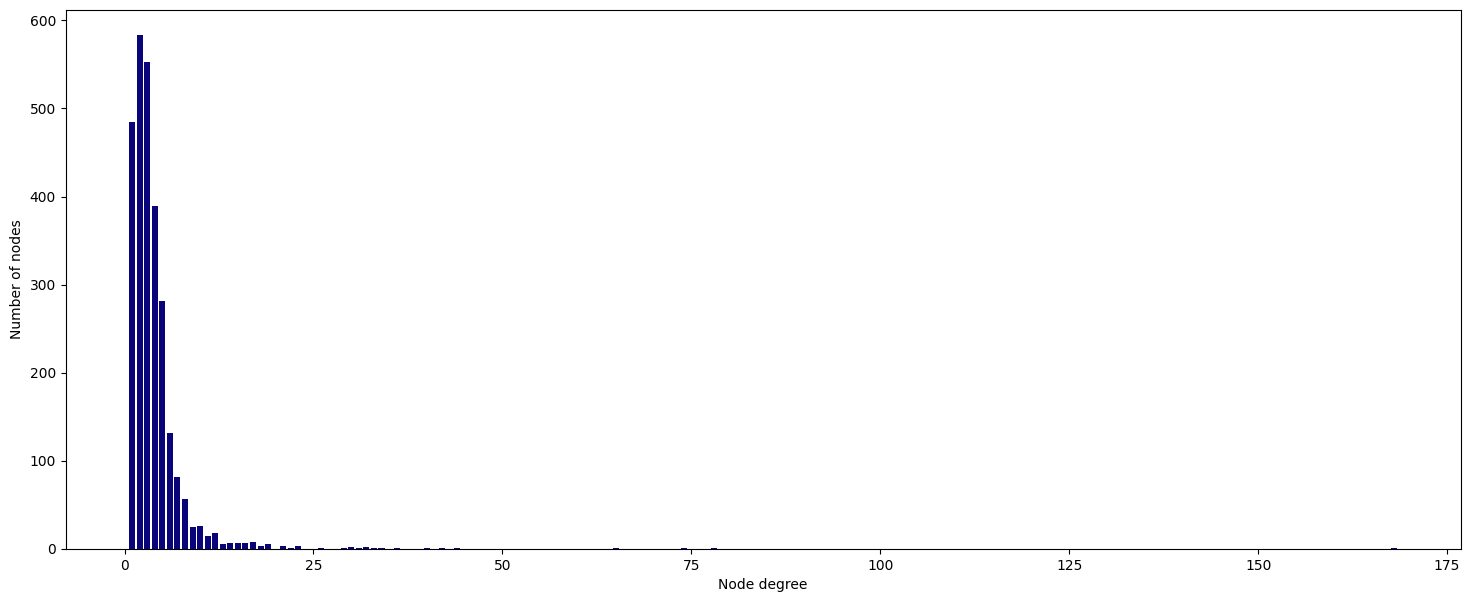

In [9]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

### GCN model with dropout()

In [15]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv

class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


### Train function

In [24]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 5

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 1 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

In [25]:
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

### 1. Training GCN with Dropout()

In [26]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.946 | Train Acc:  12.86% | Val Loss: 1.94 | Val Acc: 10.40%
Epoch   1 | Train Loss: 1.894 | Train Acc:  36.43% | Val Loss: 1.91 | Val Acc: 24.00%
Epoch   2 | Train Loss: 1.792 | Train Acc:  55.71% | Val Loss: 1.88 | Val Acc: 29.00%
Epoch   3 | Train Loss: 1.686 | Train Acc:  63.57% | Val Loss: 1.81 | Val Acc: 42.60%
Epoch   4 | Train Loss: 1.566 | Train Acc:  70.00% | Val Loss: 1.76 | Val Acc: 38.80%
Epoch   5 | Train Loss: 1.450 | Train Acc:  72.86% | Val Loss: 1.70 | Val Acc: 42.80%

GCN test accuracy: 59.00%

CPU times: total: 4.77 s
Wall time: 630 ms


### 2. Training  GCN with dropEdges

#### 2.1. GCN with dropEdges Construction

In [ ]:
class GCN_dropEdges(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

#### 2.2. Training the model

In [43]:
from torch_geometric.utils import dropout_adj

def train_dropEdges(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 5

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        edge_index1, _ = dropout_adj(data.edge_index, data.edge_attr, p=0.5)
        _, out = model(data.x, edge_index1 )
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 1 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

In [44]:

%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train_dropEdges(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.954 | Train Acc:  15.00% | Val Loss: 1.98 | Val Acc: 11.80%
Epoch   1 | Train Loss: 1.897 | Train Acc:  26.43% | Val Loss: 1.94 | Val Acc: 20.60%
Epoch   2 | Train Loss: 1.841 | Train Acc:  45.71% | Val Loss: 1.92 | Val Acc: 24.00%
Epoch   3 | Train Loss: 1.739 | Train Acc:  50.00% | Val Loss: 1.90 | Val Acc: 30.00%
Epoch   4 | Train Loss: 1.648 | Train Acc:  57.86% | Val Loss: 1.87 | Val Acc: 33.00%
Epoch   5 | Train Loss: 1.524 | Train Acc:  67.14% | Val Loss: 1.81 | Val Acc: 40.20%

GCN test accuracy: 54.30%

CPU times: total: 5.12 s
Wall time: 643 ms


### 3. Training GCN with DropNodes

In [47]:
from torch_geometric.utils import dropout_node

def train_dropNodes(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 5

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        edge_index1, _, _ = dropout_node(data.edge_index)
        _, out = model(data.x, edge_index1 )
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 1 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

In [48]:

%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train_dropNodes(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.963 | Train Acc:  13.57% | Val Loss: 1.96 | Val Acc: 13.80%
Epoch   1 | Train Loss: 1.912 | Train Acc:  25.71% | Val Loss: 1.95 | Val Acc: 16.20%
Epoch   2 | Train Loss: 1.825 | Train Acc:  37.14% | Val Loss: 1.90 | Val Acc: 29.60%
Epoch   3 | Train Loss: 1.736 | Train Acc:  50.71% | Val Loss: 1.88 | Val Acc: 28.40%
Epoch   4 | Train Loss: 1.655 | Train Acc:  57.14% | Val Loss: 1.86 | Val Acc: 30.40%
Epoch   5 | Train Loss: 1.544 | Train Acc:  60.71% | Val Loss: 1.82 | Val Acc: 33.40%

GCN test accuracy: 66.80%

CPU times: total: 5.25 s
Wall time: 659 ms


### 4. JKNet model 

In [71]:
from torch_geometric.nn import JumpingKnowledge
from torch.nn import Linear, Dropout
class JKNet(torch.nn.Module):
    def __init__(self, dataset, mode='max', num_layers=6, hidden=16):
        super(JKNet, self).__init__()
        self.num_layers = num_layers
        self.mode = mode

        self.conv0 = GCNConv(dataset.num_node_features, hidden)
        self.dropout0 = torch.nn.Dropout(p=0.5)

        for i in range(1, self.num_layers):
            setattr(self, 'conv{}'.format(i), GCNConv(hidden, hidden))
            setattr(self, 'dropout{}'.format(i), torch.nn.Dropout(p=0.5))

        self.jk = JumpingKnowledge(mode=mode)
        if mode == 'max':
            self.fc = torch.nn.Linear(hidden, dataset.num_classes)
        elif mode == 'cat':
            self.fc = torch.nn.Linear(num_layers * hidden, dataset.num_classes)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)
    def forward(self, x, edge_index):

        layer_out = []  
        for i in range(self.num_layers):
            conv = getattr(self, 'conv{}'.format(i))
            dropout = getattr(self, 'dropout{}'.format(i))
            x = dropout(F.relu(conv(x, edge_index)))
            layer_out.append(x)

        h = self.jk(layer_out)  
        h = self.fc(h)
        return h, F.log_softmax(h, dim=1)

In [72]:
%%time
jkGCN = JKNet(dataset)
print(jkGCN)

JKNet(
  (conv0): GCNConv(1433, 16)
  (dropout0): Dropout(p=0.5, inplace=False)
  (conv1): GCNConv(16, 16)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(16, 16)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): GCNConv(16, 16)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): GCNConv(16, 16)
  (dropout4): Dropout(p=0.5, inplace=False)
  (conv5): GCNConv(16, 16)
  (dropout5): Dropout(p=0.5, inplace=False)
  (jk): JumpingKnowledge(max)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
CPU times: total: 0 ns
Wall time: 4.01 ms


In [74]:
# Train
train(jkGCN, data)
# Test
acc = test(jkGCN, data)
print(f'\n test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.702 | Train Acc:  32.86% | Val Loss: 1.83 | Val Acc: 21.40%
Epoch   1 | Train Loss: 1.647 | Train Acc:  30.71% | Val Loss: 1.81 | Val Acc: 22.20%
Epoch   2 | Train Loss: 1.535 | Train Acc:  45.71% | Val Loss: 1.78 | Val Acc: 25.60%
Epoch   3 | Train Loss: 1.512 | Train Acc:  46.43% | Val Loss: 1.73 | Val Acc: 28.60%
Epoch   4 | Train Loss: 1.460 | Train Acc:  49.29% | Val Loss: 1.69 | Val Acc: 34.80%
Epoch   5 | Train Loss: 1.361 | Train Acc:  60.71% | Val Loss: 1.66 | Val Acc: 38.60%

 test accuracy: 63.30%



### 5. Training DeeperGCN

In [ ]:

class DeeperGCN(torch.nn.Module):
	def __init__(self,num_features, num_classes, dim =16, num_layers =2, drop=0.5):
		super().__init__()

		self.node_encoder = Linear(num_features, dim)
		#self.edge_encoder = Linear(data.edge_attr.size(-1), hidden_channels)
		self.h = None
		self.layers = torch.nn.ModuleList()
		for i in range(1, num_layers + 1):
			conv = GENConv(dim, dim, aggr='softmax', t=1.0, learn_t=True, num_layers=2, norm='layer')
			norm = LayerNorm(dim, elementwise_affine=True)
			act = ReLU(inplace=True)

			layer = DeepGCNLayer(conv, norm, act, block='res+', dropout=0.1,ckpt_grad=i % 3)
			self.layers.append(layer)
		self.mlp = Linear(dim, num_classes)
		self.optimizer = torch.optim.Adam(self.parameters(),lr=0.01,weight_decay=5e-4)


	def forward(self, x, edge_index):
		x = self.node_encoder(x)
		x = self.layers[0].conv(x, edge_index)

		for layer in self.layers[1:]:
			x = layer(x, edge_index)

		x = self.layers[0].act(self.layers[0].norm(x))
		x = F.dropout(x, p=0.1, training=self.training)
		x = self.mlp(x)
		self.h = x
		return x, F.log_softmax(x, dim=1)

In [27]:
%%time
#(self,num_features, num_classes, dim =16, num_layers =2, drop=0.5):
# Create GAT model
deepGCN = DeeperGCN(dataset.num_features, dataset.num_classes)
print(deepGCN)

DeeperGCN(
  (node_encoder): Linear(in_features=1433, out_features=16, bias=True)
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
  )
  (mlp): Linear(in_features=16, out_features=7, bias=True)
)
CPU times: total: 15.6 ms
Wall time: 2 ms


In [28]:


# Train
train(deepGCN, data)

# Test
acc = test(deepGCN, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

C:\Users\user\anaconda3\envs\test\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch   0 | Train Loss: 2.020 | Train Acc:  12.14% | Val Loss: 1.96 | Val Acc: 14.60%
Epoch   1 | Train Loss: 1.811 | Train Acc:  26.43% | Val Loss: 1.97 | Val Acc: 16.60%
Epoch   2 | Train Loss: 1.623 | Train Acc:  45.71% | Val Loss: 1.82 | Val Acc: 28.80%
Epoch   3 | Train Loss: 1.455 | Train Acc:  68.57% | Val Loss: 1.73 | Val Acc: 37.00%
Epoch   4 | Train Loss: 1.356 | Train Acc:  77.86% | Val Loss: 1.72 | Val Acc: 38.00%
Epoch   5 | Train Loss: 1.251 | Train Acc:  84.29% | Val Loss: 1.66 | Val Acc: 40.80%

GAT test accuracy: 54.40%



### 6. GCNII model

In [59]:
from torch_geometric.nn import GCN2Conv
class GCNII(torch.nn.Module):
	def __init__(self, num_features, num_classes, hidden_channels = 16, num_layers =2, shared_weights=True, dropout=0.0):
		super().__init__()
		self.lins = torch.nn.ModuleList()
		self.proj = Linear(1, 64)
		self.lins1 = Linear(num_features, hidden_channels)
		self.lins2  = Linear(hidden_channels, num_classes)

		self.convs = torch.nn.ModuleList()
		for layer in range(num_layers):
			self.convs.append(
				GCN2Conv(hidden_channels, 0.1, 0.5, layer + 1, shared_weights, normalize=False))
		self.h = None
		self.dropout = dropout
		self.optimizer = torch.optim.Adam(self.parameters(),lr=0.01,weight_decay=5e-4)
	def forward(self, x, edge_index):
		
		x = F.dropout(x, self.dropout, training=self.training)
		x =  self.lins1(x)
		x = x_0 = x.relu()

		for conv in self.convs:
			x = F.dropout(x, self.dropout, training=self.training)
			x = conv(x, x_0, edge_index)
			x = x.relu()
		x = F.dropout(x, self.dropout, training=self.training)
		x = self.lins2(x)
		self.h =x
		return x, x.log_softmax(dim=-1)

In [60]:
%%time

gcnii = GCNII(dataset.num_features, dataset.num_classes)
print(gcnii)

GCNII(
  (lins): ModuleList()
  (proj): Linear(in_features=1, out_features=64, bias=True)
  (lins1): Linear(in_features=1433, out_features=16, bias=True)
  (lins2): Linear(in_features=16, out_features=7, bias=True)
  (convs): ModuleList(
    (0): GCN2Conv(16, alpha=0.1, beta=0.4054651081081644)
    (1): GCN2Conv(16, alpha=0.1, beta=0.22314355131420976)
  )
)
CPU times: total: 0 ns
Wall time: 1 ms


In [61]:
# Train
train(gcnii, data)

# Test
acc = test(gcnii, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.932 | Train Acc:  13.57% | Val Loss: 1.87 | Val Acc: 17.80%
Epoch   1 | Train Loss: 1.658 | Train Acc:  41.43% | Val Loss: 1.74 | Val Acc: 31.60%
Epoch   2 | Train Loss: 1.412 | Train Acc:  62.14% | Val Loss: 1.54 | Val Acc: 51.00%
Epoch   3 | Train Loss: 1.252 | Train Acc:  67.14% | Val Loss: 1.44 | Val Acc: 55.00%
Epoch   4 | Train Loss: 1.070 | Train Acc:  75.00% | Val Loss: 1.33 | Val Acc: 61.80%
Epoch   5 | Train Loss: 0.913 | Train Acc:  81.43% | Val Loss: 1.25 | Val Acc: 65.80%

GAT test accuracy: 73.30%



### 7. t-SNE plots

C:\Users\user\anaconda3\envs\test\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\user\anaconda3\envs\test\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


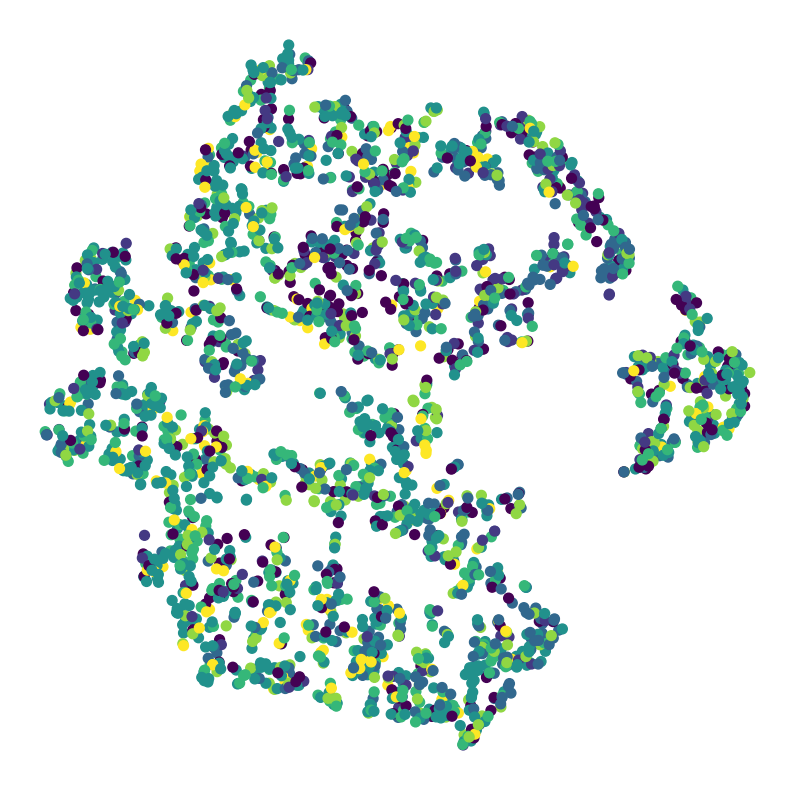

In [31]:
# Initialize new untrained model
untrained_DeeperGCN = DeeperGCN(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_DeeperGCN(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

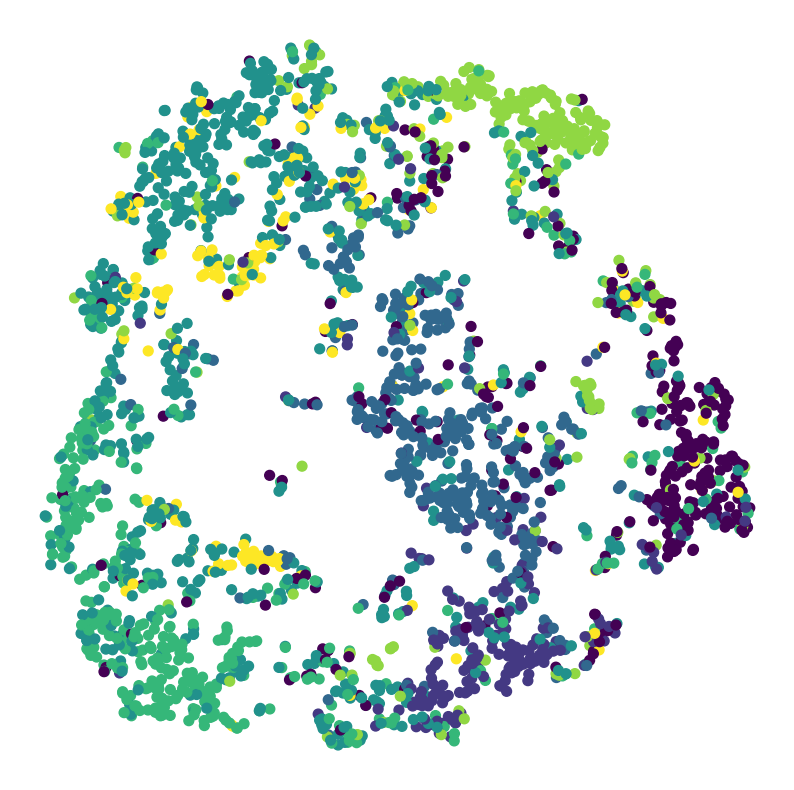

In [32]:
# Get embeddings
h, _ = deepGCN(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()